In [1]:
# 필요한 package들을 import 한다. 
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


# device 설정
# GPU를 사용할 수 있으면 사용하고, 아니면 CPU를 사용한다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Replay Memory

In [2]:
# namedtuple은 key와 index를 통해 값에 접근할 수 있다.
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


# ReplayMemory를 정의
class ReplayMemory(object):
    def __init__(self, capacity):
        # deque는 양방향 queue를 의미한다.
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        # Transition을 저장하는 부분이다.
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        # memory로부터 batch_size 길이 만큼의 list를 반환한다.
        return random.sample(self.memory, batch_size)

    def __len__(self):
        # memory의 길이를 반환한다.
        return len(self.memory)

# Network

In [3]:
class net(nn.Module):
    def __init__(self, outputs):
        super(net, self).__init__()
        self.fc1 = nn.Linear(4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, outputs)

    def forward(self, x):
#         x = x.to(device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Functions

In [4]:
def select_action(state):
    # Global 변수로 선언한다.
    global steps_done
    # random.random() >> [0.0, 1.0) 구간의 소수점 숫자를 반환한다.
    sample = random.random()
    # steps_done이 커짐에 따라 epsilon 값이 줄어든다. 
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
    math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    if sample > eps_threshold:
        with torch.no_grad():
            # 기댓값이 더 큰 action을 고르자. 
            # 바로 예를 들어 설명해보면, 아래의 논리로 코드가 진행된다.
            '''
            policy_net(state) >> tensor([[0.5598, 0.0144]])
            policy_net(state).max(1) >> ('max value', 'max 값의 index')
            policy_net(state).max(1)[1] >> index를 선택함.
            policy_net(state).max(1)[1].view(1, 1) >> tensor([[0]]) 
            '''
            # 즉, 위 예제의 경우 index 0에 해당하는 action을 선택하는 것이다.
            return policy_net(state).max(1)[1].view(1,1)
    else:
        # tensor([['index']])의 형식으로 random하게 action이 선택된다. 
        # 즉, 0 이나 1 값이 선택됨.
        return torch.tensor([[random.randrange(n_actions)]], device=device, \
        dtype=torch.long)

# Model training

In [5]:
def train_model():
    if len(memory) < BATCH_SIZE:
        return

 
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    next_state_batch = torch.cat(batch.next_state)
    reward_batch = torch.cat(batch.reward)
    

    # torch.gather(input, dim, index, *, sparse_grad=False, out=None) → Tensor
    # action_batch 에 들어있는 0 혹은 1 값으로 index를 설정하여 결과값에서 가져온다.
    # 즉, action_batch 값에 해당하는 결과 값을 불러온다.  
    current_q_values = policy_net(state_batch).gather(1, action_batch)

    
    # target_net(non_final_next_states).max(1)[0].detach() 를 하면, 
    # True 값을 갖는 원소의 개수만큼 max value 값이 모인다.  
    # 이들을 True 값의 index 위치에만 반영시키도록 하자.
    # 정리하면 한 state에서 더 큰 action을 선택한 것에 대한 value 값이 담기게 된다.  
    max_next_q_values = target_net(next_state_batch).detach().max(1)[0]
    
    target_q_values = reward_batch + (GAMMA * max_next_q_values)

    # Huber Loss 계산
    criterion = nn.SmoothL1Loss()
    loss = criterion(current_q_values, target_q_values.unsqueeze(1)) # unsqueeze(): 차원 추가 

    # Optimize parameters
    optimizer.zero_grad()
    loss.backward()
#     for param in policy_net.parameters():
#         # 모든 원소를 [ min, max ]의 범위로 clamp
# #         param.grad.data.clamp_(-1, 1)
    optimizer.step()

# Main

## Hyperparameters

In [6]:
# ==== Hyperparameters ==== #
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 1
LR = 0.001
# ========================== #

## Model loading

In [7]:
env = gym.make('CartPole-v1')

# gym의 action space에서 action의 가짓수를 얻는다.
# n_actions >> 2
n_actions = env.action_space.n

# network
policy_net = net(n_actions).to(device)
target_net = net(n_actions).to(device)

# policy network의 network parameter를 불러온다.   
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(policy_net.parameters(), LR)

# Capacity (즉, maximum length) 2000짜리 deque 이다.
memory = ReplayMemory(10000)

steps_done = 0
score_avg = 0
scores, episodes = [], []
train_start = 1000
HM_EPISODES = 10000
SHOW_EVERY = 100


episode:   0 | score avg: 12.00 | steps: 12 memory lengh:   12
episode:   1 | score avg: 12.10 | steps: 13 memory lengh:   25
episode:   2 | score avg: 12.59 | steps: 17 memory lengh:   42
episode:   3 | score avg: 13.03 | steps: 17 memory lengh:   59
episode:   4 | score avg: 14.63 | steps: 29 memory lengh:   88
episode:   5 | score avg: 14.87 | steps: 17 memory lengh:  105
episode:   6 | score avg: 14.88 | steps: 15 memory lengh:  120
episode:   7 | score avg: 16.89 | steps: 35 memory lengh:  155
episode:   8 | score avg: 16.80 | steps: 16 memory lengh:  171
episode:   9 | score avg: 16.72 | steps: 16 memory lengh:  187
episode:  10 | score avg: 16.65 | steps: 16 memory lengh:  203
episode:  11 | score avg: 15.88 | steps:  9 memory lengh:  212
episode:  12 | score avg: 16.10 | steps: 18 memory lengh:  230
episode:  13 | score avg: 16.49 | steps: 20 memory lengh:  250
episode:  14 | score avg: 16.94 | steps: 21 memory lengh:  271
episode:  15 | score avg: 16.94 | steps: 17 memory leng

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:822: UserWarning: Using a target size (torch.Size([64, 1, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


episode:  56 | score avg: 17.69 | steps: 14 memory lengh: 1020
episode:  57 | score avg: 17.02 | steps: 11 memory lengh: 1031
episode:  58 | score avg: 16.62 | steps: 13 memory lengh: 1044
episode:  59 | score avg: 15.86 | steps:  9 memory lengh: 1053
episode:  60 | score avg: 15.17 | steps:  9 memory lengh: 1062
episode:  61 | score avg: 14.85 | steps: 12 memory lengh: 1074
episode:  62 | score avg: 14.47 | steps: 11 memory lengh: 1085
episode:  63 | score avg: 14.12 | steps: 11 memory lengh: 1096
episode:  64 | score avg: 14.21 | steps: 15 memory lengh: 1111
episode:  65 | score avg: 14.09 | steps: 13 memory lengh: 1124
episode:  66 | score avg: 13.98 | steps: 13 memory lengh: 1137
episode:  67 | score avg: 14.38 | steps: 18 memory lengh: 1155
episode:  68 | score avg: 14.24 | steps: 13 memory lengh: 1168
episode:  69 | score avg: 14.42 | steps: 16 memory lengh: 1184
episode:  70 | score avg: 14.78 | steps: 18 memory lengh: 1202
episode:  71 | score avg: 14.60 | steps: 13 memory leng

episode: 190 | score avg: 16.75 | steps: 35 memory lengh: 3170
episode: 191 | score avg: 17.98 | steps: 29 memory lengh: 3199
episode: 192 | score avg: 18.58 | steps: 24 memory lengh: 3223
episode: 193 | score avg: 17.72 | steps: 10 memory lengh: 3233
episode: 194 | score avg: 17.15 | steps: 12 memory lengh: 3245
episode: 195 | score avg: 18.54 | steps: 31 memory lengh: 3276
episode: 196 | score avg: 17.78 | steps: 11 memory lengh: 3287
episode: 197 | score avg: 19.10 | steps: 31 memory lengh: 3318
episode: 198 | score avg: 20.09 | steps: 29 memory lengh: 3347
episode: 199 | score avg: 20.48 | steps: 24 memory lengh: 3371
episode: 200 | score avg: 19.94 | steps: 15 memory lengh: 3386
episode: 201 | score avg: 19.04 | steps: 11 memory lengh: 3397
episode: 202 | score avg: 18.34 | steps: 12 memory lengh: 3409
episode: 203 | score avg: 17.30 | steps:  8 memory lengh: 3417
episode: 204 | score avg: 16.47 | steps:  9 memory lengh: 3426
episode: 205 | score avg: 17.03 | steps: 22 memory leng

episode: 321 | score avg: 25.03 | steps: 36 memory lengh: 6063
episode: 322 | score avg: 23.72 | steps: 12 memory lengh: 6075
episode: 323 | score avg: 23.55 | steps: 22 memory lengh: 6097
episode: 324 | score avg: 22.20 | steps: 10 memory lengh: 6107
episode: 325 | score avg: 23.68 | steps: 37 memory lengh: 6144
episode: 326 | score avg: 23.51 | steps: 22 memory lengh: 6166
episode: 327 | score avg: 22.76 | steps: 16 memory lengh: 6182
episode: 328 | score avg: 24.08 | steps: 36 memory lengh: 6218
episode: 329 | score avg: 23.57 | steps: 19 memory lengh: 6237
episode: 330 | score avg: 23.32 | steps: 21 memory lengh: 6258
episode: 331 | score avg: 23.09 | steps: 21 memory lengh: 6279
episode: 332 | score avg: 24.38 | steps: 36 memory lengh: 6315
episode: 333 | score avg: 23.84 | steps: 19 memory lengh: 6334
episode: 334 | score avg: 24.55 | steps: 31 memory lengh: 6365
episode: 335 | score avg: 23.10 | steps: 10 memory lengh: 6375
episode: 336 | score avg: 22.69 | steps: 19 memory leng

episode: 452 | score avg: 23.91 | steps: 31 memory lengh: 9025
episode: 453 | score avg: 25.82 | steps: 43 memory lengh: 9068
episode: 454 | score avg: 24.94 | steps: 17 memory lengh: 9085
episode: 455 | score avg: 23.44 | steps: 10 memory lengh: 9095
episode: 456 | score avg: 22.90 | steps: 18 memory lengh: 9113
episode: 457 | score avg: 25.81 | steps: 52 memory lengh: 9165
episode: 458 | score avg: 26.73 | steps: 35 memory lengh: 9200
episode: 459 | score avg: 25.96 | steps: 19 memory lengh: 9219
episode: 460 | score avg: 24.76 | steps: 14 memory lengh: 9233
episode: 461 | score avg: 25.98 | steps: 37 memory lengh: 9270
episode: 462 | score avg: 26.09 | steps: 27 memory lengh: 9297
episode: 463 | score avg: 29.08 | steps: 56 memory lengh: 9353
episode: 464 | score avg: 30.77 | steps: 46 memory lengh: 9399
episode: 465 | score avg: 30.39 | steps: 27 memory lengh: 9426
episode: 466 | score avg: 29.15 | steps: 18 memory lengh: 9444
episode: 467 | score avg: 28.64 | steps: 24 memory leng

episode: 583 | score avg: 23.89 | steps: 40 memory lengh: 10000
episode: 584 | score avg: 23.30 | steps: 18 memory lengh: 10000
episode: 585 | score avg: 22.57 | steps: 16 memory lengh: 10000
episode: 586 | score avg: 22.81 | steps: 25 memory lengh: 10000
episode: 587 | score avg: 26.63 | steps: 61 memory lengh: 10000
episode: 588 | score avg: 26.37 | steps: 24 memory lengh: 10000
episode: 589 | score avg: 26.23 | steps: 25 memory lengh: 10000
episode: 590 | score avg: 25.21 | steps: 16 memory lengh: 10000
episode: 591 | score avg: 26.79 | steps: 41 memory lengh: 10000
episode: 592 | score avg: 25.61 | steps: 15 memory lengh: 10000
episode: 593 | score avg: 26.35 | steps: 33 memory lengh: 10000
episode: 594 | score avg: 26.41 | steps: 27 memory lengh: 10000
episode: 595 | score avg: 25.57 | steps: 18 memory lengh: 10000
episode: 596 | score avg: 25.01 | steps: 20 memory lengh: 10000
episode: 597 | score avg: 25.41 | steps: 29 memory lengh: 10000
episode: 598 | score avg: 24.97 | steps:

episode: 713 | score avg: 24.59 | steps: 19 memory lengh: 10000
episode: 714 | score avg: 24.03 | steps: 19 memory lengh: 10000
episode: 715 | score avg: 27.73 | steps: 61 memory lengh: 10000
episode: 716 | score avg: 26.56 | steps: 16 memory lengh: 10000
episode: 717 | score avg: 27.30 | steps: 34 memory lengh: 10000
episode: 718 | score avg: 27.17 | steps: 26 memory lengh: 10000
episode: 719 | score avg: 25.45 | steps: 10 memory lengh: 10000
episode: 720 | score avg: 24.91 | steps: 20 memory lengh: 10000
episode: 721 | score avg: 25.62 | steps: 32 memory lengh: 10000
episode: 722 | score avg: 24.56 | steps: 15 memory lengh: 10000
episode: 723 | score avg: 24.10 | steps: 20 memory lengh: 10000
episode: 724 | score avg: 23.29 | steps: 16 memory lengh: 10000
episode: 725 | score avg: 24.06 | steps: 31 memory lengh: 10000
episode: 726 | score avg: 24.55 | steps: 29 memory lengh: 10000
episode: 727 | score avg: 24.10 | steps: 20 memory lengh: 10000
episode: 728 | score avg: 23.09 | steps:

episode: 843 | score avg: 28.90 | steps: 29 memory lengh: 10000
episode: 844 | score avg: 31.61 | steps: 56 memory lengh: 10000
episode: 845 | score avg: 30.85 | steps: 24 memory lengh: 10000
episode: 846 | score avg: 33.76 | steps: 60 memory lengh: 10000
episode: 847 | score avg: 32.19 | steps: 18 memory lengh: 10000
episode: 848 | score avg: 30.77 | steps: 18 memory lengh: 10000
episode: 849 | score avg: 29.49 | steps: 18 memory lengh: 10000
episode: 850 | score avg: 27.64 | steps: 11 memory lengh: 10000
episode: 851 | score avg: 26.08 | steps: 12 memory lengh: 10000
episode: 852 | score avg: 26.87 | steps: 34 memory lengh: 10000
episode: 853 | score avg: 27.38 | steps: 32 memory lengh: 10000
episode: 854 | score avg: 26.84 | steps: 22 memory lengh: 10000
episode: 855 | score avg: 26.36 | steps: 22 memory lengh: 10000
episode: 856 | score avg: 26.52 | steps: 28 memory lengh: 10000
episode: 857 | score avg: 25.47 | steps: 16 memory lengh: 10000
episode: 858 | score avg: 25.32 | steps:

KeyboardInterrupt: 

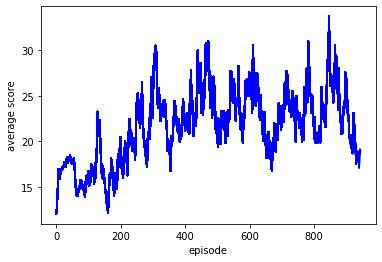

In [8]:

for episode in range(HM_EPISODES):    
    done = False
    score = 0
    steps = 0
    
    # env와 state 초기화
    state = env.reset()         # state shape >> torch.Size([1, 3, 40, 90]) 
    state = torch.tensor([state], device=device, dtype =torch.float) # state에 차원하나 추가 필요


    while not done:    
        
#         env.render()
        
        action = select_action(state)    # action result >> tensor([[0]]) or tensor([[1]])

        # 선택한 action을 대입하여 reward와 done을 얻어낸다. 
        # env.step(action.item())의 예시  
        # >> (array([-0.008956, -0.160571,  0.005936,  0.302326]), 1.0, False, {})
        next_state, reward, done, _ = env.step(action.item())        
        
        score += reward
        if done:
            reward = -1
        
        reward = torch.tensor([[reward]], device=device, dtype = torch.int)
        next_state = torch.tensor([next_state], device=device, dtype =torch.float)                

        

        # 얻어낸 transition set을 memory에 저장
        memory.push(state, action, next_state, reward)
        # (policy network에서) 최적화 한단계 수행
        
        if len(memory) >= train_start:
            train_model()

        # 다음 상태로 이동
        state = next_state
        steps += 1


        # 마찬가지로 done이 True 라면,
        if done:
            
            score_avg = 0.9 * score_avg + 0.1 * score if score_avg !=0 else score
            print('episode: {:3d} | score avg: {:3.2f} | steps:{:3d} memory lengh: {:4d}'.format(
                episode, score_avg, steps, len(memory)))
            scores.append(score_avg)
            episodes.append(episode)
            plt.plot(episodes, scores, 'b')
            plt.xlabel('episode')
            plt.ylabel('average score')
            break
   
        if score_avg > 400:
            sys.exit()
        
    
    # TARGET_UPDATE 마다 target network의 parameter를 update 한다. 
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # (episode 한번에 대한) 전체 for문 1회 종료.


    # 학습 마무리. 
print('Complete')
scores.clear
episodes.clear

